In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import sys
sys.path.append('..')

from tools.propagate import create_photon_propagator
from tools.geometry import generate_detector
from tools.utils import load_single_event, save_single_event, generate_random_params
from tools.losses import compute_loss_with_time
from tools.simulation import setup_event_simulator

import jax
import jax.numpy as jnp
import time

from jax import jit

In [2]:
default_json_filename = '../config/cyl_geom_config.json'

detector = generate_detector(default_json_filename)
detector_points = jnp.array(detector.all_points)
detector_radius = detector.S_radius
NUM_DETECTORS = len(detector_points)
Nphot = 1_000_000

temperatures = [0.1, 0.5, 1.0]

event_simulators = {temperature: setup_event_simulator(default_json_filename, Nphot, temperature) for temperature in temperatures}

# temperature is the relaxation used for overlap probability.
temperature = None
temperature_sim = 1.0

In [3]:
# is_data=True sets t0 = 0
simulate_true_data = setup_event_simulator(default_json_filename, Nphot, temperature=temperature, is_data=False, is_calibration=False)
simulate_event = event_simulators[temperature_sim]

In [4]:
from tools.utils import generate_random_params

# Generate and save a single event
key = jax.random.PRNGKey(71900)

trk_params = generate_random_params(key)
detector_params = (
    jnp.array(3),           # scatter_length
    jnp.array(0.1),         # reflection_rate
    jnp.array(10.),         # absorption_length
    jnp.array(0.001)         # gumbel_softmax_temp
)


single_event_data = jax.lax.stop_gradient(simulate_event(trk_params, detector_params, key))
save_single_event(single_event_data, trk_params, detector_params, filename='../events/test_event_data.h5', calibration_mode=False)

'../events/test_event_data.h5'

In [5]:
%%timeit

# get a random key from time
key = jax.random.PRNGKey(int(time.time()))

trk_params = generate_random_params(key)

single_event_data = jax.lax.stop_gradient(simulate_event(trk_params, detector_params, key))

21.7 ms ± 521 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
from tools.geometry import generate_detector
import jax.numpy as jnp
default_json_filename='../config/cyl_geom_config.json'
detector = generate_detector(default_json_filename)
detector_points = jnp.array(detector.all_points)
NUM_DETECTORS = len(detector_points)
print(NUM_DETECTORS)

9946


Particle Parameters:
  Energy: 575.05 MeV
  Position: [0.09, -0.66, 0.03] m
  Direction angles: theta=0.98 rad, phi=3.54 rad
  Direction vector: [-0.76, -0.32, 0.56]
Detector Parameters:
────────────────────
Scatter Length: 3.00 m
Reflection Rate: 0.10
Absorption Length: 10.00 m
Simulation Temperature for Gumbel-Softmax: 0.0010
────────────────────


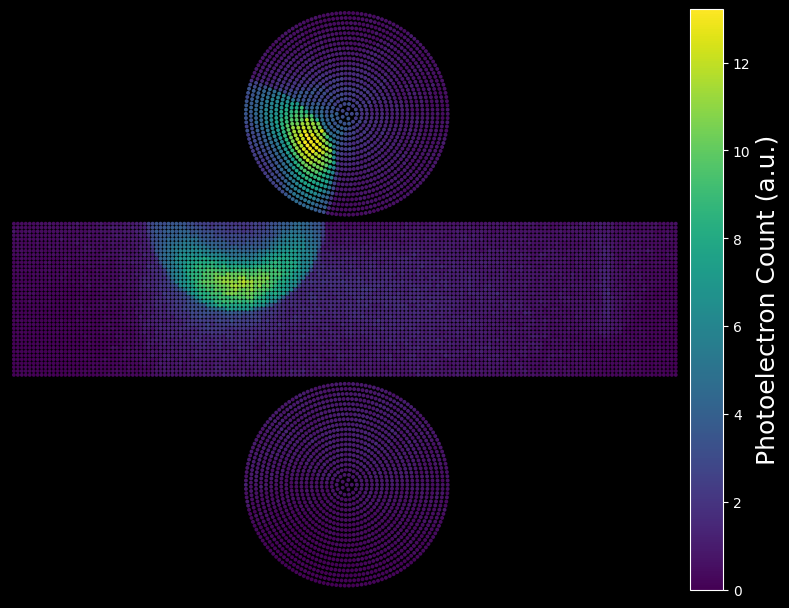

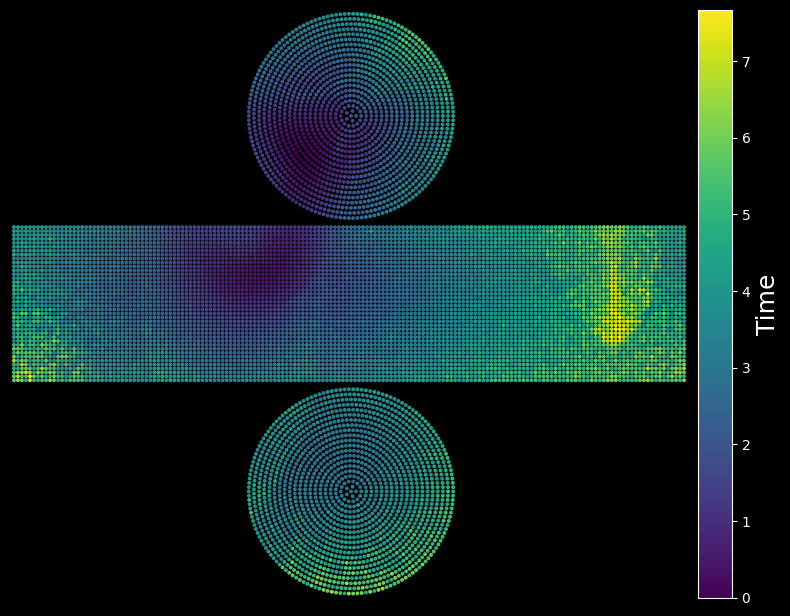

In [7]:
from tools.visualization import create_detector_display
from tools.utils import load_single_event, save_single_event, full_to_sparse, sparse_to_full, print_particle_params, print_detector_params

event_location = '../events/test_event_data.h5'

loaded_trk_params, loaded_detector_params, loaded_indices, loaded_charges, loaded_times= load_single_event(event_location, NUM_DETECTORS, calibration_mode=False)
print_particle_params(loaded_trk_params), print_detector_params(loaded_detector_params)

detector_display = create_detector_display(default_json_filename)
detector_display(loaded_indices, loaded_charges, loaded_times, file_name='../plots/event_display_charge.png', plot_time=False, log_scale=False)
detector_display(loaded_indices, loaded_charges, loaded_times, file_name='../plots/event_display_time.png', plot_time=True)

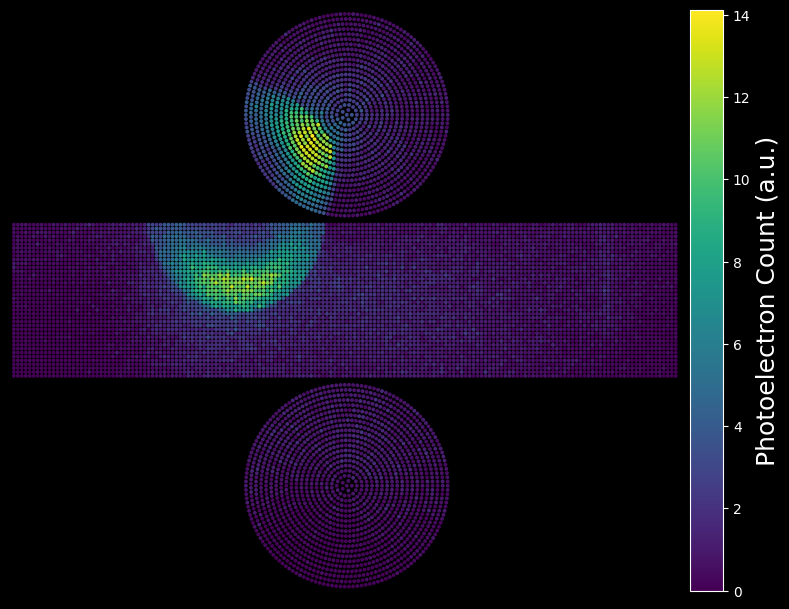

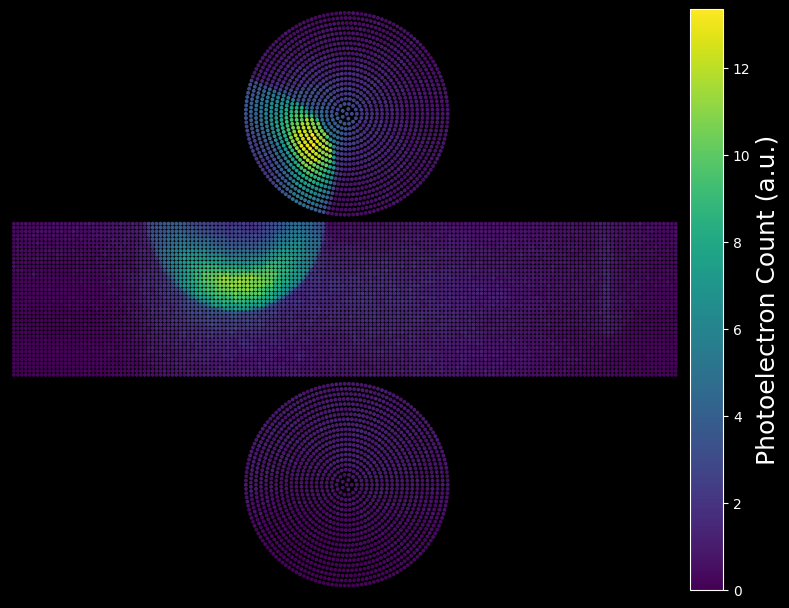

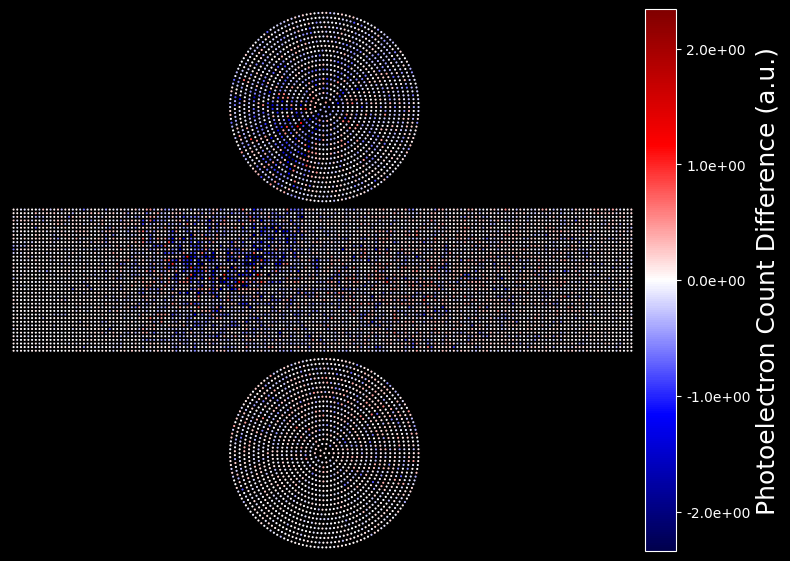

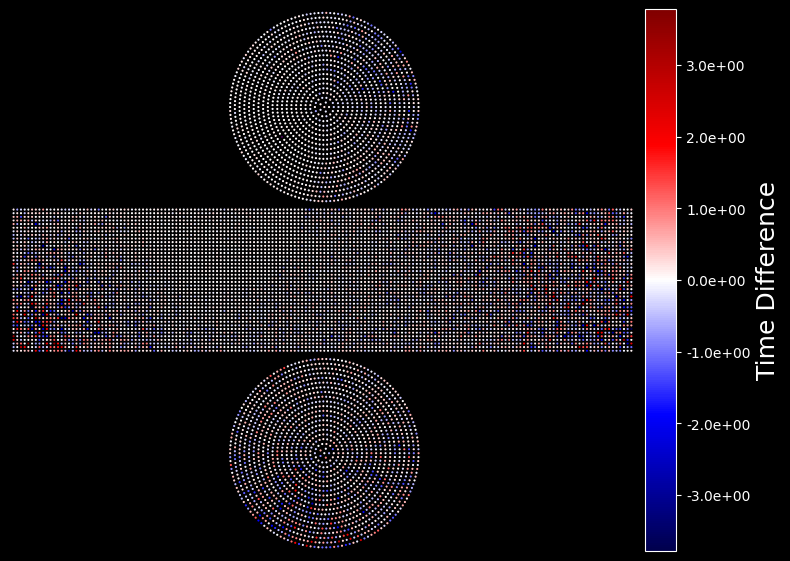

Average charge difference: 0.19968312978744507
Normalized average charge difference: 0.014144116081297398
Average time difference: 1.938035012472028e-07
Normalized average time difference: 2.073900340349155e-08


In [8]:
# Evaluate Relaxation Difference
from tools.visualization import create_detector_comparison_display

detector = generate_detector(default_json_filename)
detector_points = jnp.array(detector.all_points)
detector_radius = detector.S_radius
NUM_DETECTORS = len(detector_points)
Nphot = 500_000

# Generate events with same parameters but different temperatures
key = jax.random.PRNGKey(7109090)

# Use your existing parameter configuration
true_trk_params = generate_random_params(key)

# Generate events
event_data =  jax.lax.stop_gradient(simulate_true_data(trk_params, detector_params, key))

event_sim = simulate_event(trk_params, detector_params, key)

# Create regular displays for both temperatures
detector_display = create_detector_display(default_json_filename, sparse=False)

# Display individual events
detector_display(*event_data, file_name='temp1_display.png', plot_time=False)
detector_display(*event_sim, file_name='temp2_display.png', plot_time=False)

# Create comparison display
detector_comparison = create_detector_comparison_display(default_json_filename, sparse=False)

# Display differences with time alignment
detector_comparison(event_data, event_sim, file_name='temp_comparison_charge.png', plot_time=False)
detector_comparison(event_data, event_sim, file_name='temp_comparison_time.png', plot_time=True, align_time=True)

indices1, charges1, times1 = full_to_sparse(*event_data)
indices2, charges2, times2 = full_to_sparse(*event_sim)

# If you want to calculate averages of differences
charges_full1 = sparse_to_full(indices1, charges1, NUM_DETECTORS)
charges_full2 = sparse_to_full(indices2, charges2, NUM_DETECTORS)
charge_diff = charges_full2 - charges_full1
charge_diff_avg = jnp.mean(jnp.abs(charge_diff[charge_diff != 0]))

# Calculate time differences with alignment
times_full1 = sparse_to_full(indices1, times1, NUM_DETECTORS)
times_full2 = sparse_to_full(indices2, times2, NUM_DETECTORS)
active_times1 = times_full1 > 0
active_times2 = times_full2 > 0
times1_mean = jnp.mean(times_full1[active_times1])
times2_mean = jnp.mean(times_full2[active_times2])
times_aligned1 = jnp.where(active_times1, times_full1 - times1_mean, 0)
times_aligned2 = jnp.where(active_times2, times_full2 - times2_mean, 0)
time_diff = times_aligned2 - times_aligned1
time_diff_avg = jnp.mean(time_diff[time_diff != 0])

print(f'Average charge difference: {charge_diff_avg}')
print(f"Normalized average charge difference: {charge_diff_avg/jnp.max(charges_full1)}")
print(f'Average time difference: {time_diff_avg}')
print(f'Normalized average time difference: {time_diff_avg/jnp.max(times_full1)}')

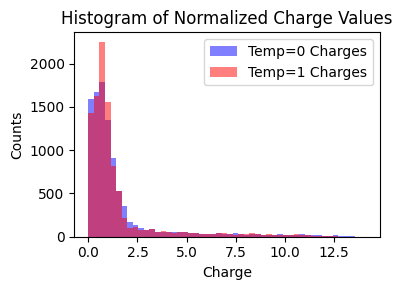

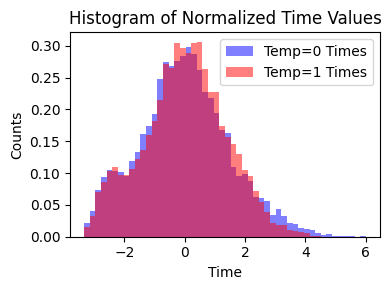

In [18]:
from matplotlib import pyplot as plt

# plot histogram of charges
plt.figure(figsize=(4, 3))

range_values = (jnp.min(jnp.concatenate([charges1, charges2])), jnp.max(jnp.concatenate([charges1, charges2])))
plt.hist(charges1, bins=50, alpha=0.5, label='Temp=0 Charges', color='b', range=range_values)
plt.hist(charges2, bins=50, alpha=0.5, label='Temp=1 Charges', color='r', range=range_values)
plt.xlabel('Charge')
plt.ylabel('Counts')
plt.title('Histogram of Normalized Charge Values')
plt.legend()
plt.tight_layout()
plt.show()

# plot histogram of times
plt.figure(figsize=(4, 3))

range_values = (jnp.min(jnp.concatenate([times_aligned1, times_aligned2])), jnp.max(jnp.concatenate([times_aligned1, times_aligned2])))
plt.hist(times_aligned1[jnp.abs(times_aligned1)>0], bins=50, alpha=0.5, label='Temp=0 Times', color='b', range=range_values, density=True)
plt.hist(times_aligned2[jnp.abs(times_aligned2)>0], bins=50, alpha=0.5, label='Temp=1 Times', color='r', range=range_values, density=True)
plt.xlabel('Time')
plt.ylabel('Counts')
plt.title('Histogram of Normalized Time Values')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# Define parameter changes as percentages of true values
param_changes = (
    jnp.array(200.0),             # Energy in MeV
    jnp.array([1.5, 0.0, 0.0]),   # position
    jnp.array([1,0]),  # direction
)

key_id = 149790000
key = jax.random.PRNGKey(key_id)

true_params = generate_random_params(key)
true_data =  jax.lax.stop_gradient(simulate_true_data(true_params, detector_params, key))

print_particle_params(true_params)

Particle Parameters:
  Energy: 652.69 MeV
  Position: [-0.82, -0.14, -0.42] m
  Direction angles: theta=1.01 rad, phi=3.99 rad
  Direction vector: [-0.56, -0.64, 0.53]


In [23]:
# Part 1: Data Generation
import numpy as jnp
from functools import partial
import pickle
from tqdm import tqdm
from jax import grad, jit, vmap, value_and_grad
from tools.losses import compute_simplified_loss

def create_loss_and_grad_fn(simulator, lambda_intensity=0.5, lambda_time=1.0):
    @jit
    def loss_and_grad_fn(params):
        def loss_fn(p):
            simulated_data = simulator(p, detector_params, key)
            return compute_simplified_loss(detector_points, *true_data, *simulated_data, lambda_intensity=lambda_intensity, lambda_time=lambda_time)
        return value_and_grad(loss_fn)(params)
    return loss_and_grad_fn

def generate_param_ranges(true_params, param_changes, num_points=121):
    param_ranges = []
    for i, (true_param, change) in enumerate(zip(true_params, param_changes)):
        if i in [1, 2]:  # position and direction
            start = true_param[0] - change[0]
            end = true_param[0] + change[0]
        else:  # opening angle and intensity
            start = true_param - change
            end = true_param + change
        param_ranges.append(jnp.linspace(start, end, num_points))
    return param_ranges

def generate_plot_data(param_index, param_values, simulator):
    losses = []
    gradients = []

    loss_and_grad_fn = create_loss_and_grad_fn(simulator, lambda_time=0.000001)

    for new_value in param_values:
        new_params = list(true_params)
        if param_index in [1, 2]:  # position and direction
            new_params[param_index] = new_params[param_index].at[0].set(new_value)
        else:  # opening angle and intensity
            new_params[param_index] = new_value

        new_params = tuple(new_params)
        loss, grad = loss_and_grad_fn(new_params)
        gradient = grad[param_index]
        if param_index in [1, 2]:
            gradient = gradient[0]

        losses.append(loss)
        gradients.append(gradient)

    return jnp.array(losses), jnp.array(gradients)

def generate_analysis_data(true_params, param_changes, temperatures, simulators, num_points=121):
    """Generate and save all analysis data."""
    # Generate parameter ranges
    param_ranges = generate_param_ranges(true_params, param_changes, num_points)
    param_names = ['Energy', 'Position X', 'Theta']

    # Store all data in a dictionary
    analysis_data = {
        'param_ranges': param_ranges,
        'param_names': param_names,
        'true_params': true_params,
        'temperatures': temperatures,
        'results': {}
    }

    # Generate data for each parameter and temperature
    for param_idx, param_name in enumerate(tqdm(param_names, desc="Parameters")):
        param_values = param_ranges[param_idx]
        analysis_data['results'][param_name] = {}

        for temp in tqdm(temperatures, desc=f"Temperatures for {param_name}", leave=False):
            losses, gradients = generate_plot_data(param_idx, param_values, simulators[temp])
            analysis_data['results'][param_name][temp] = {
                'losses': losses,
                'gradients': gradients
            }

    return analysis_data

def save_analysis_data(analysis_data, filename='analysis_data.pkl'):
    """Save the analysis data to a file."""
    with open(filename, 'wb') as f:
        pickle.dump(analysis_data, f)

def load_analysis_data(filename='analysis_data.pkl'):
    """Load the analysis data from a file."""
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [24]:
analysis_data = generate_analysis_data(true_params, param_changes, temperatures, event_simulators)
save_analysis_data(analysis_data)
print('Ready to Plot')

Parameters: 100%|██████████| 3/3 [03:16<00:00, 65.53s/it]            

Ready to Plot


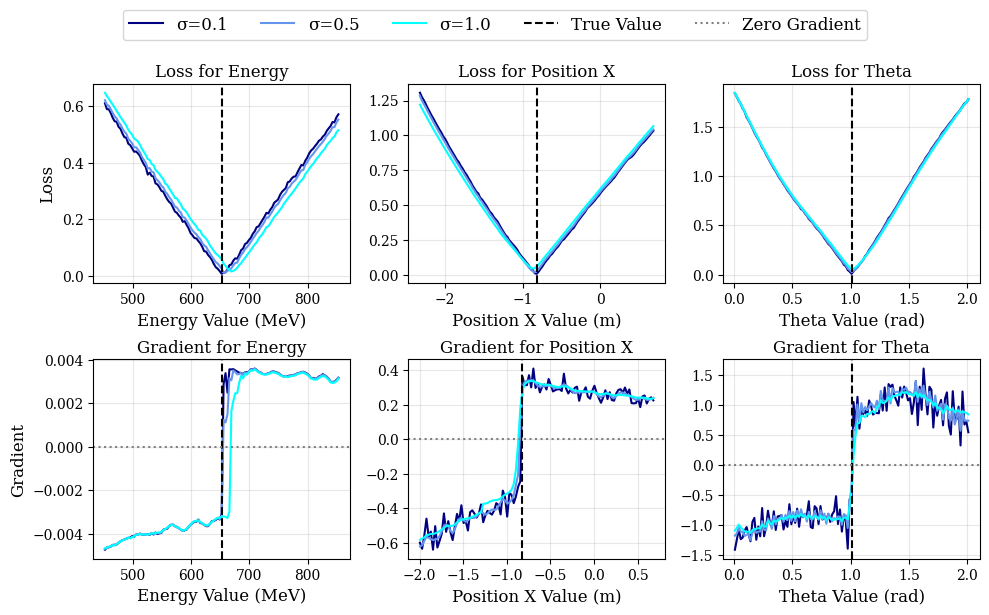

In [25]:
from matplotlib import rcParams, rc
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10

def plot_analysis_results(analysis_data):
    """
    Plot the analysis results with a common legend for all subplots.

    Args:
        analysis_data: Dictionary containing all the analysis data
    """
    param_names = analysis_data['param_names']
    temperatures = analysis_data['temperatures']
    true_params = analysis_data['true_params']

    colors = ['navy', 'cornflowerblue', 'cyan']

    fig, axs = plt.subplots(2, 3, figsize=(10, 6))

    # Lists to store legend handles and labels
    all_lines = []
    all_labels = []

    # First row for losses, second row for gradients
    for param_idx, param_name in enumerate(param_names):
        param_values = analysis_data['param_ranges'][param_idx]
        true_value = true_params[param_idx] if param_idx not in [1, 2] else true_params[param_idx][0]

        ax_loss = axs[0, param_idx]
        ax_grad = axs[1, param_idx]

        for temp_idx, temp in enumerate(temperatures):
            results = analysis_data['results'][param_name][temp]
            losses = results['losses']
            gradients = results['gradients']

            label = f'σ={temp}'
            color = colors[temp_idx]

            # Plot loss and gradient
            line_loss = ax_loss.plot(param_values, losses, color=color, lw=1.5)[0]
            line_grad = ax_grad.plot(param_values, gradients, color=color, lw=1.5)[0]

            # Only store temperature-related legend items from the first parameter
            if param_idx == 0:
                all_lines.append(line_loss)
                all_labels.append(label)

        # Add reference lines
        true_line = ax_loss.axvline(x=true_value, color='black', linestyle='--')
        ax_grad.axvline(x=true_value, color='black', linestyle='--')

        zero_line = ax_grad.axhline(y=0, color='gray', linestyle=':')

        # Only store reference lines from the first parameter
        if param_idx == 0:
            all_lines.extend([true_line, zero_line])
            all_labels.extend(['True Value', 'Zero Gradient'])

        # Configure axes without individual legends
        ax_loss.set_title(f'Loss for {param_name}', pad=5, fontsize=12)
        if param_idx == 0:
            ax_loss.set_xlabel(f'{param_name} Value (MeV)', fontsize=12)
        elif param_idx == 1:
            ax_loss.set_xlabel(f'{param_name} Value (m)', fontsize=12)
        else:
            ax_loss.set_xlabel(f'{param_name} Value (rad)', fontsize=12)
        if param_idx == 0:
            ax_loss.set_ylabel('Loss', fontsize=12)
        ax_loss.grid(True, alpha=0.3)

        ax_grad.set_title(f'Gradient for {param_name}', pad=5, fontsize=12)
        if param_idx == 0:
            ax_grad.set_xlabel(f'{param_name} Value (MeV)', fontsize=12)
        elif param_idx == 1:
            ax_grad.set_xlabel(f'{param_name} Value (m)', fontsize=12)
        else:
            ax_grad.set_xlabel(f'{param_name} Value (rad)', fontsize=12)
        if param_idx == 0:
            ax_grad.set_ylabel('Gradient', fontsize=12)
        ax_grad.grid(True, alpha=0.3)

    #plt.suptitle('Loss and Gradient Analysis for Different Temperatures', fontsize=16)

    # Adjust layout to make room for the legend
    plt.tight_layout()

    # Add common legend below all subplots
    fig.legend(all_lines, all_labels,
              loc='center',
              bbox_to_anchor=(0.5, 1.04),
              ncol=len(all_lines),
              fontsize=12,
              bbox_transform=fig.transFigure)

    # Adjust the bottom margin to make room for the legend
    plt.subplots_adjust(bottom=0.15)

    return fig, axs

# Usage
analysis_data = load_analysis_data()
fig, axs = plot_analysis_results(analysis_data)

plt.savefig('1D_loss_and_grads_'+str(key_id)+'_'+str(Nphot)+'.pdf', bbox_inches='tight')
plt.show()

In [27]:
# 2D Valley Analysis
# This is the case where we move closer to the wall and increase the opening angle. The gradient is the steepest in the direction of the valley.

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
import matplotlib.pyplot as plt

# True parameters
true_params = (
    jnp.array(400.0),  # energy MeV
    jnp.array([0.0, 0.0, 0.0]),  # position
    jnp.array([1.0, 1.0]) # theta and phi in radians
)

key = jax.random.PRNGKey(1009)
# 
true_params = generate_random_params(key)

# Parameter changes
param_changes = (
    jnp.array(100.0),  # energy (only changing first component)
    jnp.array([1.0, 0.0, 0.0]),  # position (only changing first component)
    jnp.array([0.5, 0.0]) # theta and phi in radians
)

print(true_params)

(Array(714.4469, dtype=float32), Array([-0.10234414,  0.0183907 ,  0.10433596], dtype=float32), Array([1.5722094, 2.9872928], dtype=float32))


In [28]:
simulate_event = event_simulators[0.5]

Outer loop: 100%|██████████| 81/81 [05:15<00:00,  3.90s/it]


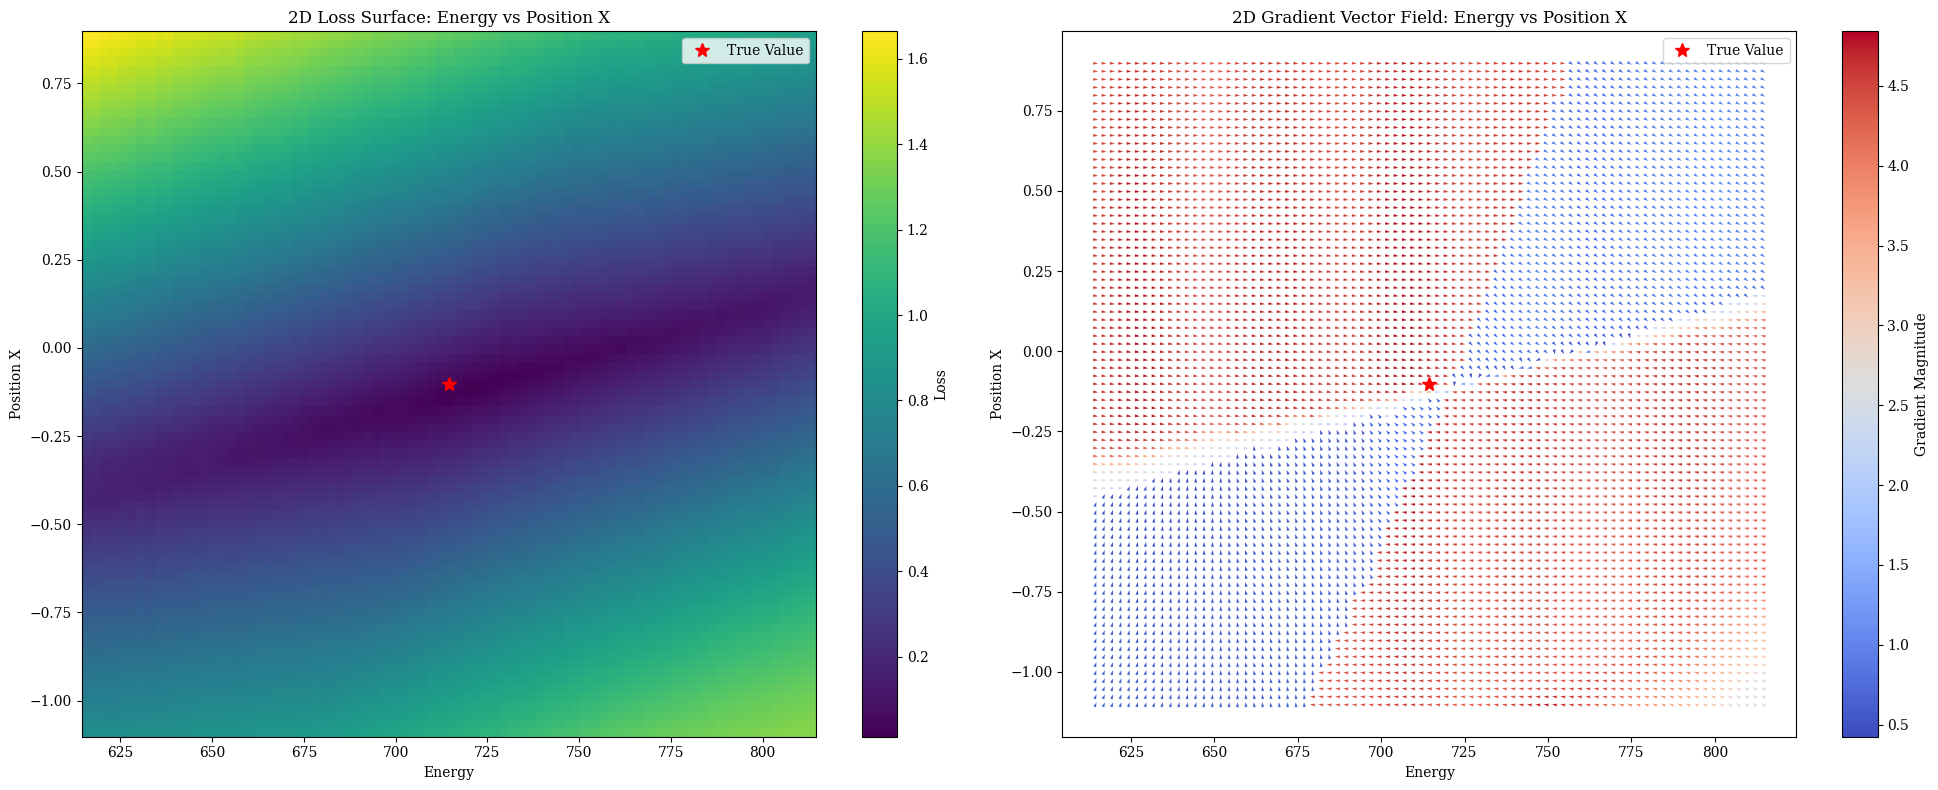

In [56]:
from tools.losses import compute_softmin_loss
from tqdm import tqdm

# Gradient scales
gradient_scales = jnp.array([0.001, 1, 1])
# gradient_scales = jnp.array([1.0, 1.0, 1.0, 1.0])

# Generate true data (without gradients)
key = jax.random.PRNGKey(1)
true_data = jax.lax.stop_gradient(simulate_true_data(true_params, detector_params, key))

true_data = (true_data[0], true_data[1])

def generate_param_ranges(true_params, param_changes, num_points=51):
    param_ranges = []
    for i, (true_param, change) in enumerate(zip(true_params, param_changes)):
        if i in [1, 2]:  # position and direction
            start = true_param[0] - change[0]
            end = true_param[0] + change[0]
        else:  # opening angle and intensity
            start = true_param - change
            end = true_param + change
        param_ranges.append(jnp.linspace(start, end, num_points))
    return param_ranges

@jit
def loss_and_grad(params):
    def loss_fn(params):
        simulated_data = simulate_event(params, detector_params, key)
        return compute_simplified_loss(detector_points, *true_data, *simulated_data, lambda_intensity=0.5, lambda_time=1.0)
    return value_and_grad(loss_fn)(params)

def generate_2d_plot_data(param_index1, param_index2, param_values1, param_values2):
    losses = jnp.zeros((len(param_values1), len(param_values2)))
    gradients = jnp.zeros((len(param_values1), len(param_values2), 2))

    total1 = len(param_values1)
    total2 = len(param_values2)
    
    for i, value1 in tqdm(enumerate(param_values1), total=total1, desc="Outer loop"):
        for j, value2 in enumerate(param_values2):
            new_params = list(true_params)
    
            if param_index1 in [1, 2]:
                new_params[param_index1] = new_params[param_index1].at[0].set(value1)
            else:
                new_params[param_index1] = value1
    
            if param_index2 in [1, 2]:
                new_params[param_index2] = new_params[param_index2].at[0].set(value2)
            else:
                new_params[param_index2] = value2
    
            new_params = tuple(new_params)
    
            loss, grad = loss_and_grad(new_params)
            gradient1 = grad[param_index1][0] if param_index1 in [1, 2] else grad[param_index1]
            gradient2 = grad[param_index2][0] if param_index2 in [1, 2] else grad[param_index2]
    
            # Rescale gradients
            gradient1 /= gradient_scales[param_index1]
            gradient2 /= gradient_scales[param_index2]
    
            losses = losses.at[i, j].set(loss)
            gradients = gradients.at[i, j].set(jnp.array([gradient1, gradient2]))

    return losses, gradients

# # Generate parameter ranges
# num_points = 81
# param_ranges = generate_param_ranges(true_params, param_changes, num_points)

# # Choose two parameters to vary (e.g., opening angle and intensity)
# param_index1, param_index2 = (0, 1)
# param_names = ['Energy', 'Position X', 'Theta']

# # Generate 2D plot data
# losses, gradients = generate_2d_plot_data(param_index1, param_index2, param_ranges[param_index1], param_ranges[param_index2])

# # Plot results
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# # Plot 2D loss surface
# im = ax1.imshow(losses.T, extent=[param_ranges[param_index1][0], param_ranges[param_index1][-1],
#                                   param_ranges[param_index2][0], param_ranges[param_index2][-1]],
#                 origin='lower', aspect='auto', cmap='viridis')
# ax1.set_title(f'2D Loss Surface: {param_names[param_index1]} vs {param_names[param_index2]}')
# ax1.set_xlabel(param_names[param_index1])
# ax1.set_ylabel(param_names[param_index2])
# fig.colorbar(im, ax=ax1, label='Loss')

# # Plot 2D gradient vector field
# X, Y = jnp.meshgrid(param_ranges[param_index1], param_ranges[param_index2])
# U = -1 * gradients[:, :, 0].T
# V = -1 * gradients[:, :, 1].T

# # Normalize gradients for better visualization
# norm = jnp.sqrt(U**2 + V**2)
# U_norm = U / norm
# V_norm = V / norm

# ax2.quiver(X, Y, U_norm, V_norm, norm, cmap='coolwarm', pivot='mid')
# ax2.set_title(f'2D Gradient Vector Field: {param_names[param_index1]} vs {param_names[param_index2]}')
# ax2.set_xlabel(param_names[param_index1])
# ax2.set_ylabel(param_names[param_index2])
# fig.colorbar(ax2.collections[0], ax=ax2, label='Gradient Magnitude')

# # Add markers for true parameter values
# true_value1 = true_params[param_index1] if param_index1 not in [1, 2] else true_params[param_index1][0]
# true_value2 = true_params[param_index2] if param_index2 not in [1, 2] else true_params[param_index2][0]
# ax1.plot(true_value1, true_value2, 'r*', markersize=10, label='True Value')
# ax2.plot(true_value1, true_value2, 'r*', markersize=10, label='True Value')

# ax1.legend()
# ax2.legend()

# plt.tight_layout()
# plt.show()

Outer loop: 100%|██████████| 81/81 [05:00<00:00,  3.71s/it]


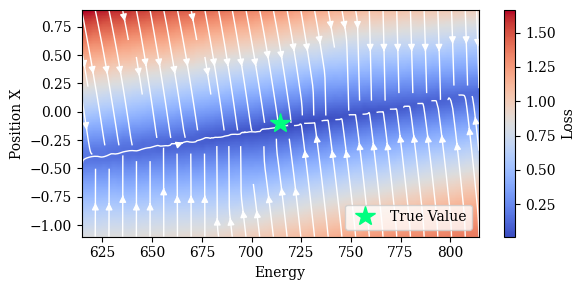

Outer loop: 100%|██████████| 81/81 [04:59<00:00,  3.70s/it]


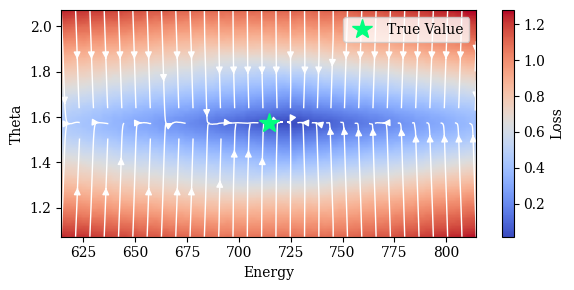

Outer loop: 100%|██████████| 81/81 [05:05<00:00,  3.78s/it]


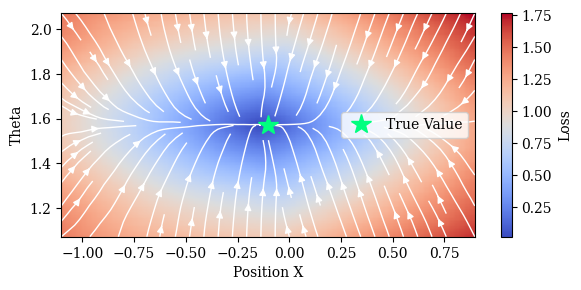

In [101]:
def make_2D_grad_plot():
    #Create a single plot
    fig, ax = plt.subplots(figsize=(6, 3))
    
    # Plot 2D loss surface
    im = ax.imshow(losses.T, extent=[param_ranges[param_index1][0], param_ranges[param_index1][-1],
                                   param_ranges[param_index2][0], param_ranges[param_index2][-1]],
                  origin='lower', aspect='auto', cmap='coolwarm')
    fig.colorbar(im, ax=ax, label='Loss')
    
    # Create truly equally spaced coordinate arrays
    x_min, x_max = float(param_ranges[param_index1][0]), float(param_ranges[param_index1][-1])
    y_min, y_max = float(param_ranges[param_index2][0]), float(param_ranges[param_index2][-1])
    n_points_x = len(param_ranges[param_index1])
    n_points_y = len(param_ranges[param_index2])
    
    # Force equal spacing
    x = np.linspace(x_min, x_max, n_points_x)
    y = np.linspace(y_min, y_max, n_points_y)
    
    X, Y = np.meshgrid(x, y)
    
    # Convert gradients to numpy
    U = -1 * np.array(gradients[:, :, 0].T)
    V = -1 * np.array(gradients[:, :, 1].T)
    
    # Normalize gradients for better visualization
    norm = np.sqrt(U**2 + V**2)
    # Avoid division by zero
    norm = np.where(norm == 0, 1, norm)
    U_norm = U / norm
    V_norm = V / norm
    
    # Add streamplot on top of loss surface
    strm = ax.streamplot(X, Y, U_norm, V_norm, 
                        color='white',  # Using white for visibility
                        density=1.,      # Adjust density of streamlines
                        linewidth=1,    # Adjust line width
                        arrowsize=1)    # Adjust arrow size
    
    # Add marker for true parameter value
    true_value1 = true_params[param_index1] if param_index1 not in [1, 2] else true_params[param_index1][0]
    true_value2 = true_params[param_index2] if param_index2 not in [1, 2] else true_params[param_index2][0]
    ax.plot(true_value1, true_value2, color='springgreen', marker='*', linewidth=0, markersize=15, label='True Value')
    
    #ax.set_title(f'Loss Surface with Gradient Streamlines: {param_names[param_index1]} vs {param_names[param_index2]}')
    ax.set_xlabel(param_names[param_index1])
    ax.set_ylabel(param_names[param_index2])
    ax.legend()
    plt.gca().set_xlim(x_min,x_max)
    plt.tight_layout()
    figname = f'../plots/2D_Grad_{param_names[param_index1]}_{param_names[param_index2]}.pdf'
    plt.savefig(figname)
    plt.show()


# Generate parameter ranges
num_points = 81
param_ranges = generate_param_ranges(true_params, param_changes, num_points)

idx_combinations = [(0,1), (0,2), (1,2)]

for idx_combo in idx_combinations:
    param_index1, param_index2 = idx_combo

    # Generate 2D plot data
    losses, gradients = generate_2d_plot_data(param_index1, param_index2, param_ranges[param_index1], param_ranges[param_index2])
    make_2D_grad_plot()

True Parameters:
Particle Parameters:
  Energy: 714.45 MeV
  Position: [-0.10, 0.02, 0.10] m
  Direction angles: theta=1.57 rad, phi=2.99 rad
  Direction vector: [-0.99, 0.15, -0.00]

Modified Parameters:
Particle Parameters:
  Energy: 714.45 MeV
  Position: [0.80, 0.02, 0.10] m
  Direction angles: theta=0.51 rad, phi=0.86 rad
  Direction vector: [0.32, 0.37, 0.87]


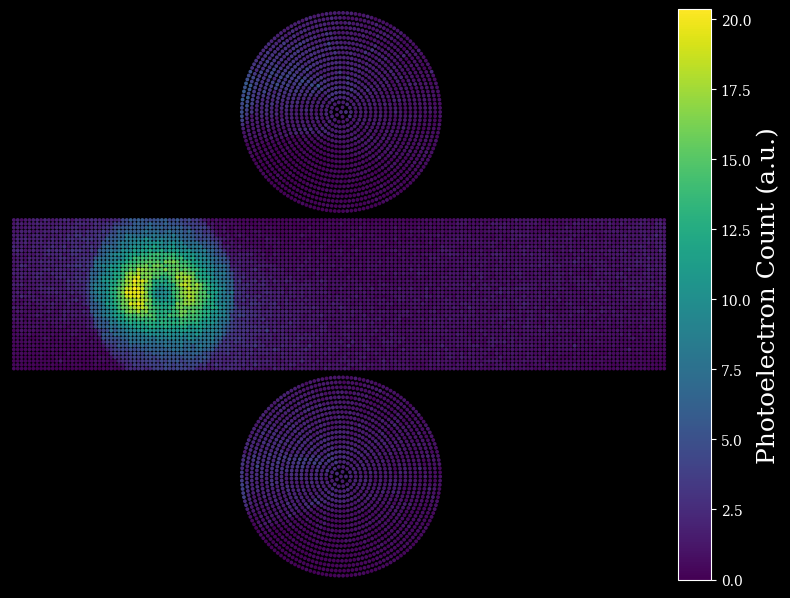

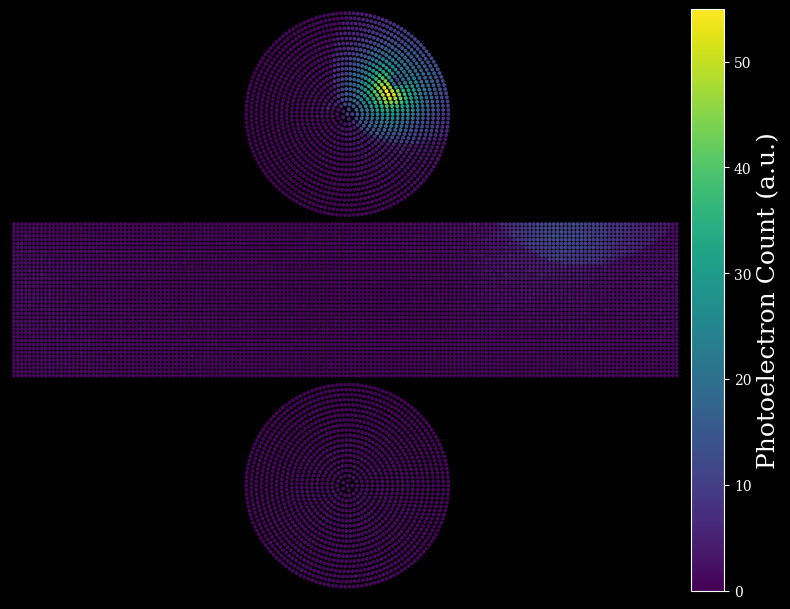

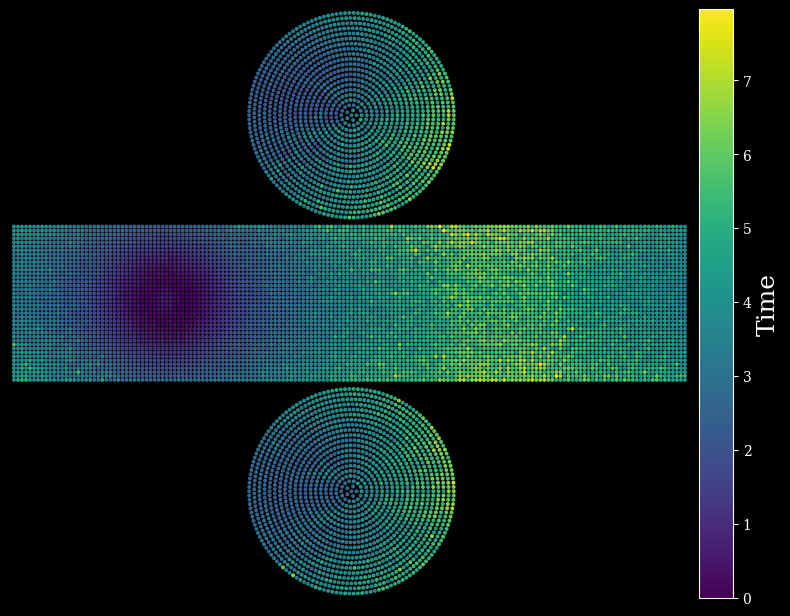

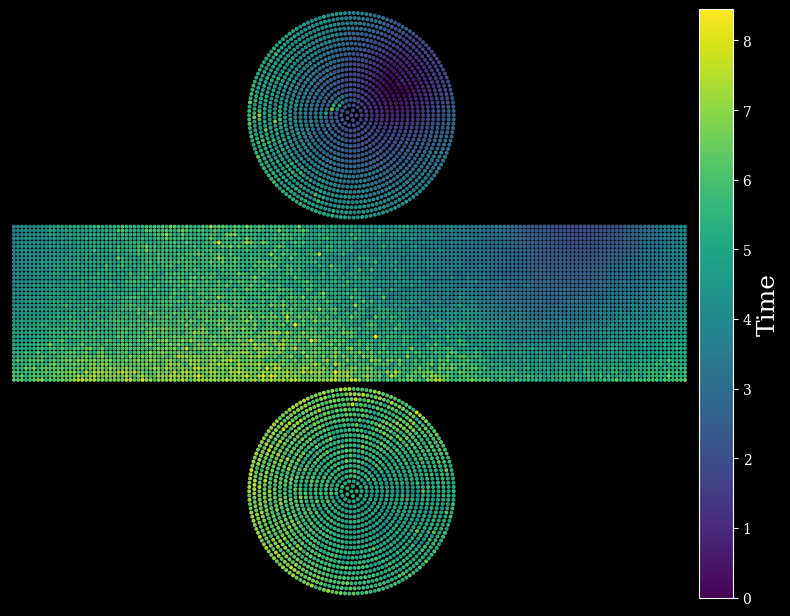

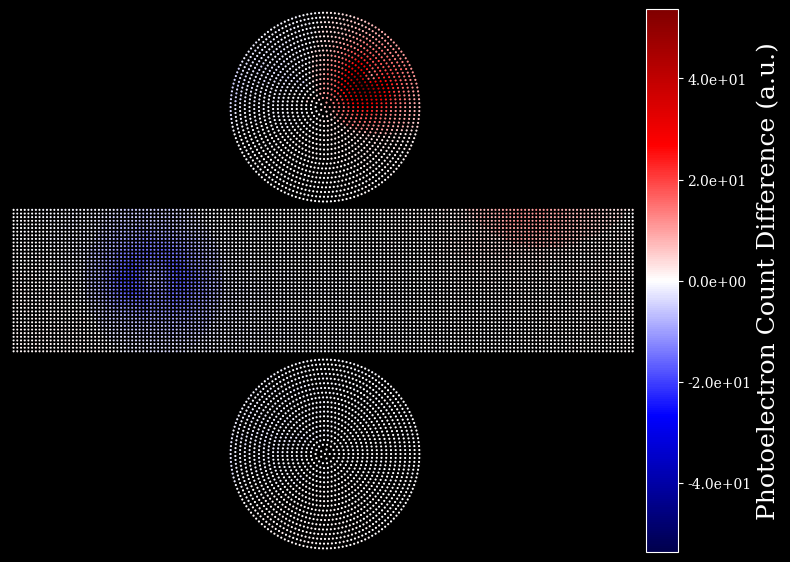

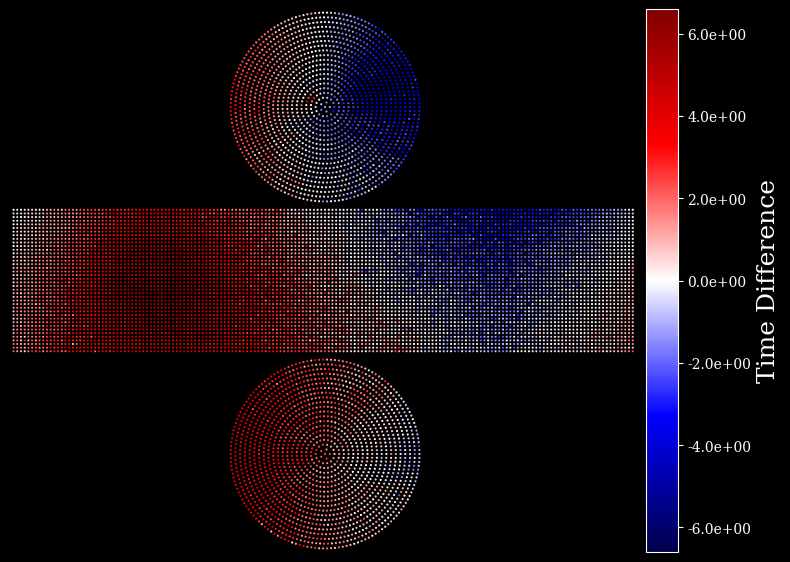

In [102]:
# Create displays for true parameters and modified parameters

# Get a new random key
key_display = jax.random.PRNGKey(42)

# Create modified parameters by applying changes based on param_index1 and param_index2
modified_params = list(true_params)

# Modify first parameter (param_index1)
if param_index1 == 1:  # Position (vector parameter)
    modified_params[param_index1] = modified_params[param_index1].at[0].set(
        true_params[param_index1][0] + 0.9 * param_changes[param_index1][0]
    )
elif param_index1 == 2:  # Direction (vector parameter)
    # normalize the direction vector before setting it
    direction_vector = true_params[param_index1] + 0.9 * param_changes[param_index1][0]
    modified_params[param_index1] = direction_vector / jnp.linalg.norm(direction_vector)
else:  # Energy (scalar parameter)
    modified_params[param_index1] = true_params[param_index1] + 0.9 * param_changes[param_index1]

# Modify second parameter (param_index2)
if param_index2 == 1:  # Position (vector parameter)
    modified_params[param_index2] = modified_params[param_index2].at[0].set(
        true_params[param_index2][0] + 0.9 * param_changes[param_index2][0]
    )
elif param_index2 == 2:  # Direction (vector parameter)
    # normalize the direction vector before setting it
    direction_vector = true_params[param_index2] + 0.9 * param_changes[param_index2][0]
    modified_params[param_index2] = direction_vector / jnp.linalg.norm(direction_vector)
else:  # Energy (scalar parameter)
    modified_params[param_index2] = true_params[param_index2] + 0.9 * param_changes[param_index2]

modified_params = tuple(modified_params)

# Print both parameter sets
print("True Parameters:")
print_particle_params(true_params)
print("\nModified Parameters:")
print_particle_params(modified_params)

# Simulate events with both parameter sets
true_event_data = simulate_event(true_params, detector_params, key_display)
modified_event_data = simulate_event(modified_params, detector_params, key_display)

# Create detector display for visualization
detector_display = create_detector_display(default_json_filename ,sparse=False)

# Display the events
detector_display(*true_event_data, file_name='true_params_display.png', plot_time=False)
detector_display(*modified_event_data, file_name='modified_params_display.png', plot_time=False)

# Also create time plots
detector_display(*true_event_data, file_name='true_params_display_time.png', plot_time=True)
detector_display(*modified_event_data, file_name='modified_params_display_time.png', plot_time=True)

# Create comparison display to see differences
detector_comparison = create_detector_comparison_display(default_json_filename, sparse=False)
detector_comparison(true_event_data, modified_event_data, file_name='params_comparison.png', plot_time=False)
detector_comparison(true_event_data, modified_event_data, file_name='params_comparison_time.png', plot_time=True)